In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
#import matplotlib; matplotlib.use('Agg')
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors_test as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re
import acceptance_psf_eastrogam as aaa
import photon_spectrum
import evaporating_black_hole_template as dm_template

In [2]:
filelist1 = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
filelist = ['bremss_healpix_reshuffled_61templates.fits', 'bremss_healpix_reshuffled_61templates.fits', 'pi0_decay_healpix_reshuffled_61templates.fits', 'pi0_decay_healpix_reshuffled_61templates.fits', 'ics_isotropic_healpix_reshuffled_61templates.fits', 'ics_isotropic_healpix_reshuffled_61templates.fits']
evermore_shifted = np.asarray([
    [33, 21, 49],
    [154, 112, 82],
    [241, 149, 91],
    [142, 52, 38],
    [33, 21, 49],
])/256

point_sources = ['Pointsources_central_23deg_61energybins.fits']

#exposure_time = 4.1e6 #.13 years 47 days
exposure_time = 4.1e8 #13 years
#exposure_time = 4.1e9 #130 years
#exposure_time = 4.1e11 #13000 years
#exposure_time = 4.1e16 #13000 years
#exposure_time = 3.154e10

acceptance_interp = aaa.get_acceptance_interp() #put in the energy in MeV!
angle_interp = aaa.get_angle_interp()

central_energies = np.array([1.22474487e+00, 1.54186244e+00, 1.94108981e+00, 2.44368729e+00,
       3.07642002e+00, 3.87298335e+00, 4.87579715e+00, 6.13826494e+00,
       7.72761772e+00, 9.72849432e+00, 1.22474487e+01, 1.54186244e+01,
       1.94108981e+01, 2.44368729e+01, 3.07642002e+01, 3.87298335e+01,
       4.87579715e+01, 6.13826494e+01, 7.72761772e+01, 9.72849432e+01,
       1.22474487e+02, 1.54186244e+02, 1.94108981e+02, 2.44368729e+02,
       3.07642002e+02, 3.87298335e+02, 4.87579715e+02, 6.13826494e+02,
       7.72761772e+02, 9.72849432e+02, 1.22474487e+03, 1.54186244e+03,
       1.94108981e+03, 2.44368729e+03, 3.07642002e+03, 3.87298335e+03,
       4.87579715e+03, 6.13826494e+03, 7.72761772e+03, 9.72849432e+03,
       1.22474487e+04, 1.54186244e+04, 1.94108981e+04, 2.44368729e+04,
       3.07642002e+04, 3.87298335e+04, 4.87579715e+04, 6.13826494e+04,
       7.72761772e+04, 9.72849432e+04, 1.22474487e+05, 1.54186244e+05,
       1.94108981e+05, 2.44368729e+05, 3.07642002e+05, 3.87298335e+05,
       4.87579715e+05, 6.13826494e+05, 7.72761772e+05, 9.72849431e+05,
       1.22474487e+06])




In [3]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    hdu1 = readfile(filelist1[0])
    
    if inner20:
        numpix = np.linspace(0, hdu1[0].header['NPIX']-1, num = hdu1[0].header['NPIX'])
        NSIDE = int(hdu1[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        vec = hp.ang2vec(np.pi/2, 0)
        ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)[ipix_disc20]
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu1[0].header['NPIX']-1, num = hdu1[0].header['NPIX'])
        NSIDE = int(hdu1[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #print(sum(~np.isnan(test20)))
        #testbin = np.reshape(test20, (128*3, 1536//3))
        
    return test20

def get_energy_index(E_desired):
    idx = find_nearest(central_energies, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_deltaE(n):
    energybins = central_energies
    bins_in_lin = np.log10(energybins)[n]
    #spacing = 0.05691431 #old spacing
    spacing = 0.17609125905568124 #new spacing
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return deltaE
    

In [4]:
e = 30 #GeV
e_togev = e
print(dmj.darksusy2(40, e_togev, channel = 5))

2.626696934215368e-05


In [5]:
#dark matter template
    
energies = np.copy(central_energies)
    
dm_temp = []
dm_templates_tot = []

cross_sec = 1.4e-26
dm_mass = 40 #GeV

delt = []

for index in range(30, 40):
    energybin = energies[index]
    print('energy here in GeV:')
    print(energybin/1e3)
    bins_in_lin = np.log10(energybin)
    deltae = get_deltaE(index)
    
    delt.append(deltae)
    
    highe = (energybin+deltae)/1e3 #to GeV
    lowe = (energybin-deltae)/1e3 #to GeV
    data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_sec, massx = dm_mass, for_normals = True, energyhere = energybin/1e3)[1]*deltae ##units of per second per str per cm^2
    #need to cut this to be inner 20 degrees
    #dm_temp.append(np.nansum(data50))
    dm_temp.append(np.nansum(data50)) #units of photons cm^-2 per sec
    print('--------------------------------------')
dm_templates_tot.append(np.asarray(dm_temp)/.38/196608) #photons per cm^2 per sec per sr, .38 is delta omega


energy here in GeV:
1.22474487
sigmav: 1.4e-26
mass: 40 GeV
total annihilations: 0.05772129144599554
--------------------------------------
energy here in GeV:
1.54186244
sigmav: 1.4e-26
mass: 40 GeV
total annihilations: 0.06126961929025964
--------------------------------------
energy here in GeV:
1.94108981
sigmav: 1.4e-26
mass: 40 GeV
total annihilations: 0.0668569253777458
--------------------------------------
energy here in GeV:
2.4436872899999997
sigmav: 1.4e-26
mass: 40 GeV
total annihilations: 0.07515735259536684
--------------------------------------
energy here in GeV:
3.07642002
sigmav: 1.4e-26
mass: 40 GeV
total annihilations: 0.08699035885992158
--------------------------------------
energy here in GeV:
3.87298335
sigmav: 1.4e-26
mass: 40 GeV
total annihilations: 0.10312471301691786
--------------------------------------
energy here in GeV:
4.87579715
sigmav: 1.4e-26
mass: 40 GeV
total annihilations: 0.12543844962699943
--------------------------------------
energy here i

NameError: name 'normals' is not defined

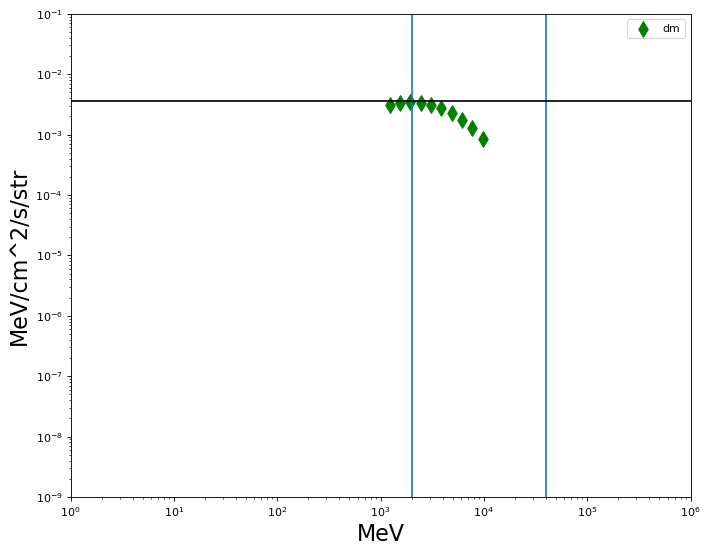

In [12]:
labels = [ 'dm']
stile = [ "d"]
energies = np.copy(central_energies)
fntsz=20
plt.close()
plt.figure(figsize=(10, 8), dpi=80)



normals = np.copy(dm_templates_tot)
plt.scatter(energies[30:40], normals*13*np.pi/delt*energies[30:40]**2, label = labels[0], marker = stile[0], s = 100, color = 'green')
plt.axvline(x=2e3)
plt.axvline(x=40e3)
plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.axhline(y = 1e3*3.6e-6, color = 'black')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-9, 1e-1)
plt.xlim(1e0, 1e6)

plt.legend()

In [8]:
print(np.max(normals/delt*energies[30:40]**2))
print(1e3*3.6e-6/np.max(normals/delt*energies[30:40]**2))

8.394897674511453e-05
42.8831909521697


In [10]:
def darksusy2(massparticle, energy, channel = 5):
    x = np.loadtxt('yield_DS_keith40.dat', dtype=str).T
    energies = x[1].astype(np.float)
    yieldperann = x[2].astype(np.float)
    
    #get point based on energy
    
    interpolated_ds = log_interp1d2(energies, yieldperann)
    
    try:
        interpolated_ds(energy)
    except ValueError:
        return 0
    
    return interpolated_ds(energy) #returns in per GeV

def log_interp1d2(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

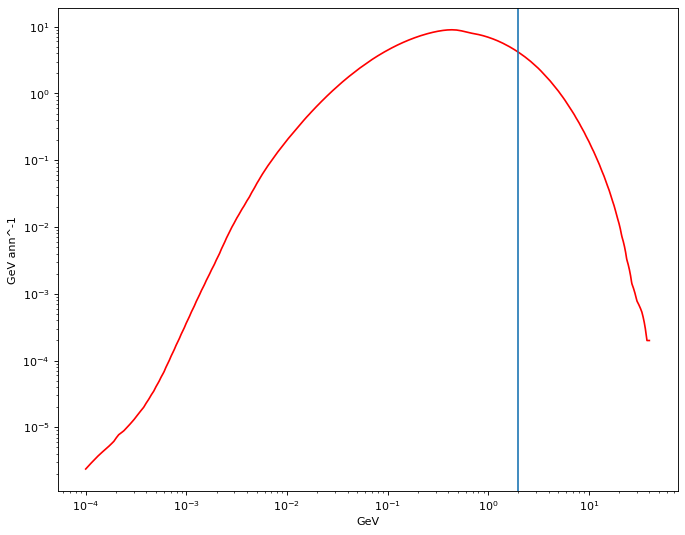

In [11]:
x = np.loadtxt('yield_DS_keith40.dat', dtype=str).T
y = np.loadtxt('yield_DS_keith100.dat', dtype=str).T
z = np.loadtxt('yield_DS_keith1.dat', dtype=str).T
a = np.loadtxt('yield_DS_keith20.dat', dtype=str).T

    
energiestest = x[1].astype(np.float)
yieldperann = x[2].astype(np.float)

energies2 = y[1].astype(np.float)
yieldperann2 = y[2].astype(np.float)

energies3 = z[1].astype(np.float)
yieldperann3 = z[2].astype(np.float)

energies4 = a[1].astype(np.float)
yieldperann4 = a[2].astype(np.float)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(energiestest, yieldperann*energiestest, color= 'red')
#plt.plot(energies2, yieldperann2, color= 'purple')
#plt.plot(energies3, yieldperann3, color= 'blue')
#plt.plot(energies4, yieldperann4, color= 'orange')

'''
plt.scatter(1e-3, darksusy2(40, 1e-3, channel = 5))
plt.scatter(1e-2, darksusy2(40, 1e-2, channel = 5))
plt.scatter(1e-1, darksusy2(40, 1e-1, channel = 5))
plt.scatter(1e1, darksusy2(40, 1e1, channel = 5))
'''

plt.yscale('log')
plt.xscale('log')
plt.ylabel('GeV ann^-1')
plt.xlabel('GeV')
plt.axvline(x=2)
#plt.axvline(40)
#plt.axvline(100)
#plt.axvline(1)
#plt.axvline(20)

0.0002027867040628561
17.752643185542077


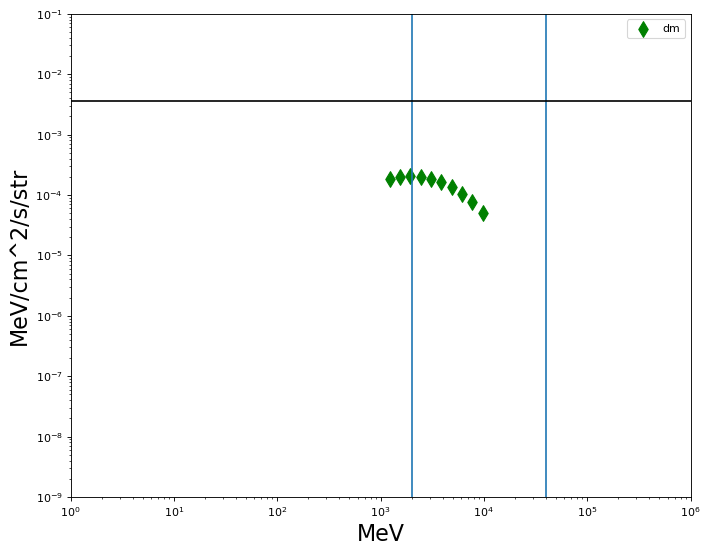

In [5]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import math

def nfw_profile_density(r, gamma = 1):
    #need to eventually normalize to local density (4 GeV/cm^2)
    #also normalize to fraction of DM in black holes
    r_s = 20 #kpc
    #make sure r is in kpc
    #rho_0 = get_rho0(massBH, gamma_forrho0 = gamma)
    rho_0 = get_rho0() #GeV/cm^3
    rho = rho_0/(r/r_s)**(gamma)/((1+r/r_s)**(3-gamma)) #.4 GeV/cm^3
    return rho

def get_rho0(gamma_forrho0 = 1):
    #calculating the initial rho_0
    r = 8.25 #kpc
    R_s = 20 #kpc
    rho_NFW = 0.4 #BHs/cm^3, should be BHs/cm^3
    rho_0 = (r/R_s)**(gamma_forrho0)*rho_NFW*(1+r/R_s)**(3-gamma_forrho0)
    #print('rho_0: {}'.format(rho_0))
    #rho_0 = .257
    return rho_0

def i_hate_trig(theta, l):
    R_GC = 8.25 #kpc
    theta_radians = theta/180*np.pi

    r = np.sqrt(l**2+R_GC**2-2*l*R_GC*math.cos(theta_radians))

    #B = np.arcsin(l*np.sin(theta)/r)
    #phi = 180-theta-B
    
    return r
    
    
def range_over_l(theta, gamma_here = 1):
    l = np.linspace(1, 60, 10000) #in kpc
    r = i_hate_trig(theta, l)
    #print(r)

    density = nfw_profile_density(r, gamma = gamma_here)
    #print(density)

    
    return l, density

def get_long_lat(longlatboo = True):

    filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
    hdu = fits.open(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = longlatboo)

    #all indices within 20 deg
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    #all indices within 25 deg
    ipix_disc25 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(25), inclusive = False)
    
    #the l and b values we want:
    
    testl = degrees[0][ipix_disc25]
    testb = degrees[1][ipix_disc25]
    
    #need to find the values of testl that are greater than 200 and subtract 360 from them
    
    where_large = np.argwhere(testl > 200)
    testl[where_large] = testl[where_large]-360

    return np.array(testl), np.array(testb), ipix_disc20, ipix_disc25
    #return np.array(testb), np.array(testl)
    #return np.array(degrees[1]), np.array(degrees[0])


def get_j_factors(gam = 1):

    btest, ltest, indices20, indices = get_long_lat()

    thetas = np.sqrt(btest**2+ltest**2)
    
    integral = []
    
    #ls are in kpc
    
    for theta in thetas:
        #get the NFW density, and the lengths
        ls, rho = range_over_l(theta, gamma_here = gam)
        n_BH = rho #*1e-4 #this also includes rho_0, can also use 1e-4 for PBH as DM 
        ls_incm3 = ls*3.086e21
        integral.append(np.trapz(n_BH**2, x = ls_incm3)) #trapezoidal rule, with n_Bh on y axis and the length on x
    integral = np.asarray(integral) #in GeV/cm^2?
            
    return thetas, integral, indices20, indices#*lum/4/np.pi #units of GeV/cm^-2? 
    #return thetas, integral#*lum/4/np.pi #units of GeV/cm^-2? 



def make_image(integral):
    
    b, l = get_long_lat()
    hdu = fits.open('Bremss_00320087_E_50-814008_MeV_healpix_128.fits')
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    index = hp.ang2pix(NSIDE, l, b, lonlat = True)

    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    
    inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
    inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
    inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
    
    
    data4 = hdu[0].data
    test20 = np.copy(data4)
    test20[inner_20] = np.nan
    test20[index] = integral*1e-30
    #print(test20.shape)
    
    #print(b[np.where(integral == np.nanmax(integral))])
    #print(l[np.where(integral == np.nanmax(integral))])
        
    #hp.mollview(np.log10(np.log10(test20)), rot=(0,0,90))
    hp.mollview(np.log10(test20))
    
def darksusy(massparticle, highe, lowe, channel = 5):
    x = np.loadtxt('yield_DS_keith40.dat', dtype=str).T
    
    energies = x[1].astype(np.float)
    yieldperann = x[2].astype(np.float)
    
    good_energies = np.where((energies <= highe) & (energies > lowe))
    #print('how many good energies: {}'.format(len(good_energies[0])))
    
    final_integral = np.trapz(yieldperann[good_energies], x = energies[good_energies])
    #print('integrated darksusy: {}'.format(final_integral))
    
    return final_integral #returns in counts per energy bin
    
    #Need to integrate over the energy bin that we are considering
    
def get_dNdE(highenergy, lowenergy, massx = 40, sigmav = 1.4e-26, analyze_data = False, for_normals = False):
    thetas, integral, indices20, indices25 = get_j_factors(gam = 1.2) #in GeV^2/cm^5?, gamma 1.2
    print('sigmav: {}'.format(sigmav))

    
    #now we need to add the integral back into the array where it was originally
    blank_array = np.empty(196608)
    blank_array[:] = 0
    
    count = 0
    blank_array[indices25] = integral
    #for index in indices25:
        #blank_array[index] = integral[count]
        #count +=1
    #blank_array[indices20] = np.nan
    #hp.mollview(np.log10(blank_array), coord = 'G')
    
    #print('mass of dark matter: {}'.format(massx))
    if analyze_data:
        dnde = 1
    else:
        dnde = darksusy(massx, highenergy, lowenergy, channel = 5)
    #dnde = 1
    #print('dnde: {}'.format(dnde))
    #make_image(integral)
    
    if for_normals:
        #need to only return the inner 20 degrees
        new_arr = blank_array[indices20]
        return thetas, new_arr*dnde*sigmav/massx**2/8/np.pi#/5938
    
    return thetas, blank_array*dnde*sigmav/massx**2/8/np.pi#/5938#/1e3#/5910 #units of photons  per str per sec per cm^2, 5910 for area
    #do I need the 1e3?

